<h2>HUXt examples.</h2>

This notebook contains several examples of how to use the 1D and 2D versions of HUXt provided is this package, as described in Owens et al (2020).

In [1]:
import numpy as np
import HUXt as H
import astropy.units as u
import matplotlib.pyplot as plt
import time
%matplotlib inline

(<Figure size 1008x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ae628bdf88>)

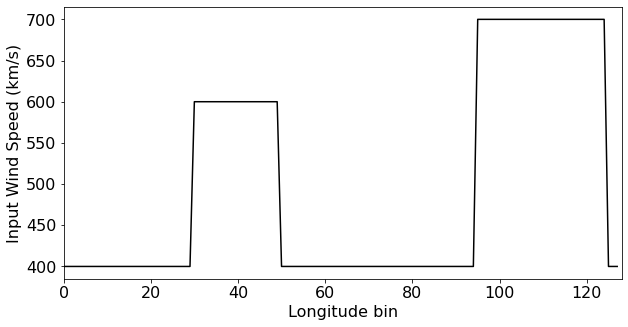

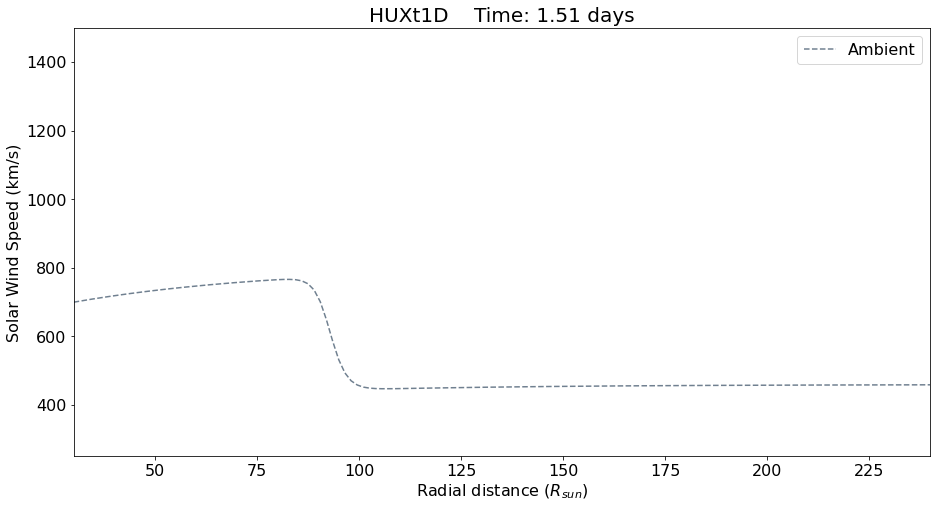

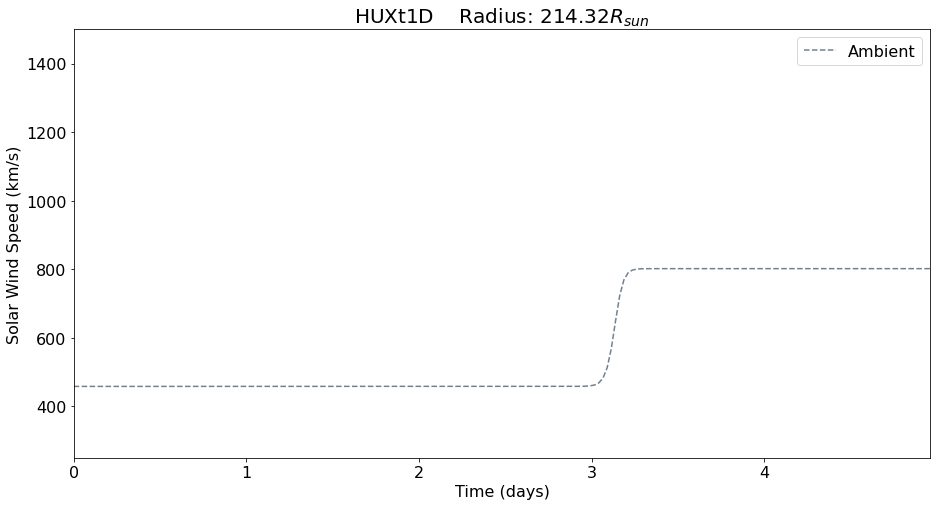

In [4]:
# Run HUXt1D with user specified boundary conditions and no CMEs

#Form boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

# This boundary condition looks like
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(v_boundary,'k-')
ax.set_xlabel('Longitude bin')
ax.set_ylabel('Input Wind Speed (km/s)')
ax.set_xlim(0,128)

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt1D(v_boundary=v_boundary, lon=0.0*u.deg, simtime=5*u.day, dt_scale=4, rmin=30*u.solRad)

# Solve these conditions, with no ConeCMEs added.
cme_list = []
model.solve_opt(cme_list)

# Plot the radial profile of the ambient wind profile at a fixed time (in days). 
t = 1.5*u.day
model.plot_radial(t, 'ambient')

# Plot the time series of the ambient wind profile at a fixed radius. 
r = 1.0*u.AU
model.plot_timeseries(r, 'ambient')

(<Figure size 1008x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ae63cc03c8>)

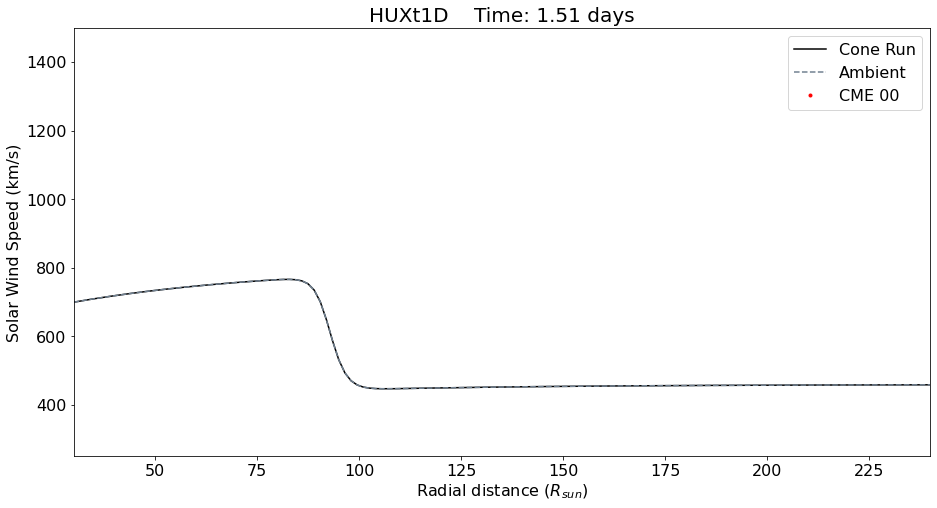

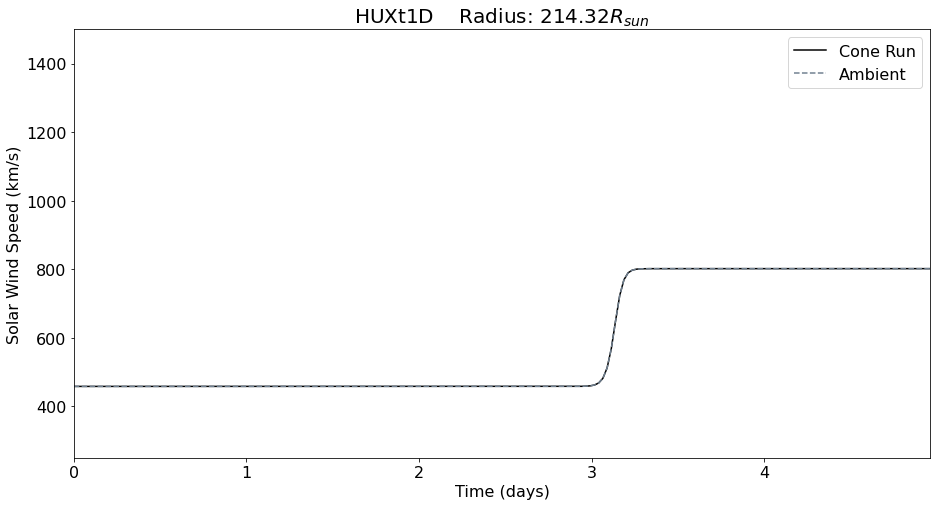

In [5]:
# Now lets run HUXt1D with the same background ambient wind and a cone cme.
# Launch the CME half a day after the simulation, at 0 longitude, 30 degree width, speed 850km/s and thickness=5 solar radii
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

# Run the model, and this time save the results to file. 
model.solve_opt(cme_list, save=True, tag='1d_conecme_test')

# Plot the radial profile and time series of both the ambient and ConeCME solutions at a fixed time (in days). 
# Save both to file as well. These are saved in HUXt>figures>HUXt1D
t = 1.5*u.day
model.plot_radial(t, 'both', save=True, tag='1d_cone_test_radial')

r = 1.0*u.AU
model.plot_timeseries(r, 'both', tag='1d_cone_test_radial')

(<Figure size 1008x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ae64109388>)

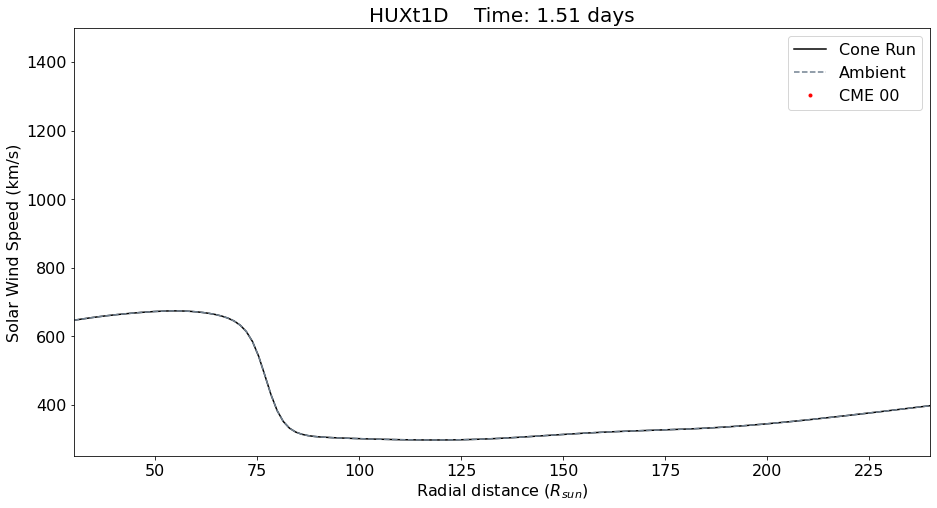

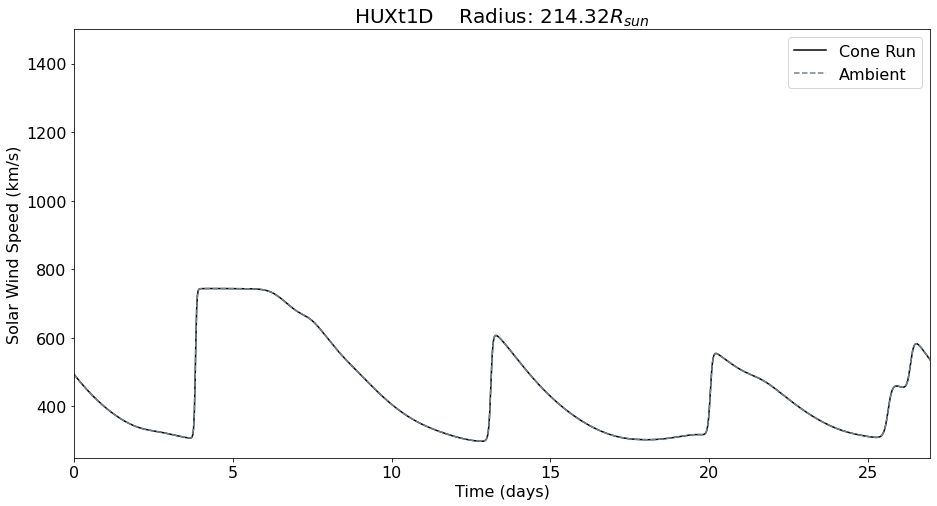

In [8]:
# We could also use boundary condtions derived from HelioMAS simulations of a Carrington rotation. 
cr_num = 2124 #This was in August 2010
model = H.HUXt1D(cr_num=cr_num, lon=0.0*u.deg, simtime=27*u.day, dt_scale=4)

# Solve this with the ConeCME used in the last simulation.
model.solve_opt(cme_list)

# Plot the radial profile and time series of both the ambient and ConeCME solutions at a fixed time (in days). 
# Save both to file as well.
t = 1.5*u.day
model.plot_radial(t, 'both')

r = 1.0*u.AU
model.plot_timeseries(r, 'both')

In [12]:
#The HUXt1D amd HUXt2D classes provide the most-user friendly means to run the model. But if 
#more flexibility is needed in how the boundary conditions are set up, for example in
#efficient handling of large ensembles, there's a series of functions that can be
#used as shown here 

###############################################################################
#generate the input timeseries
###############################################################################

#simulation time
tmax=27*u.day

#define radial grid parameters
rmin=30.0*u.solRad
rmax=240.0*u.solRad
Nr=140
r, dr, rrel, Nr= H.radial_grid(r_min=rmin, r_max=rmax, Nr=Nr)

#compute the time step to meet the CFL condition
constants=H.huxt_constants()
vmax=constants['v_max']
Tsyn=constants['synodic_period']
dt=dr.to(u.km)/vmax
nsteps=int(tmax.to('s')/dt)

#convert longitudinal boundary to a timeseries at a fixed Carrington lontigude
#Time runs in opposite direction to Carrington longitude
v_boundary_ts=np.flipud(v_boundary)
#convert from longitude to time
t_boundary_ts=np.linspace(0.0*u.s,Tsyn,v_boundary.size)
#set up the required timestep
tin=np.linspace(0.0*u.s,tmax.to('s'),nsteps)
#interpolate the speed time series
vin=np.interp(tin,t_boundary_ts,v_boundary_ts)

###############################################################################
#run optimised HUXt
###############################################################################
#run once for numba compilation
tout,vout=H.solve_upwind_Rout(v_input=vin, dt=dt, tmax=27*u.day, rin = rmin, rout= 215.0*u.solRad, dr=1.4747*u.solRad)
#now bnenchmark it
start = time.time()
times,vout=H.solve_upwind_Rout(v_input=vin, dt=dt, tmax=27*u.day, rin = rmin, rout= 215.0*u.solRad, dr=1.4747*u.solRad)
end = time.time()
print("Elapsed (after compilation) = {:3.4f} seconds".forma (end - start))

#plot the input and output time series

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(tin.to(u.day),vin,'k-')
ax.plot(tout.to(u.day),vout,'r-')
ax.set_xlabel('Days past simulation start')
ax.set_ylabel('Solar Wind Speed (km/s)')


TypeError: not all arguments converted during string formatting

In [5]:
# HUXt2D runs in a similar manner. 
#Form boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt2D(v_boundary=v_boundary, simtime=5*u.day, dt_scale=4)

model.solve(cme_list) # This takes a minute or so to run. 


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x20a414656a0>)

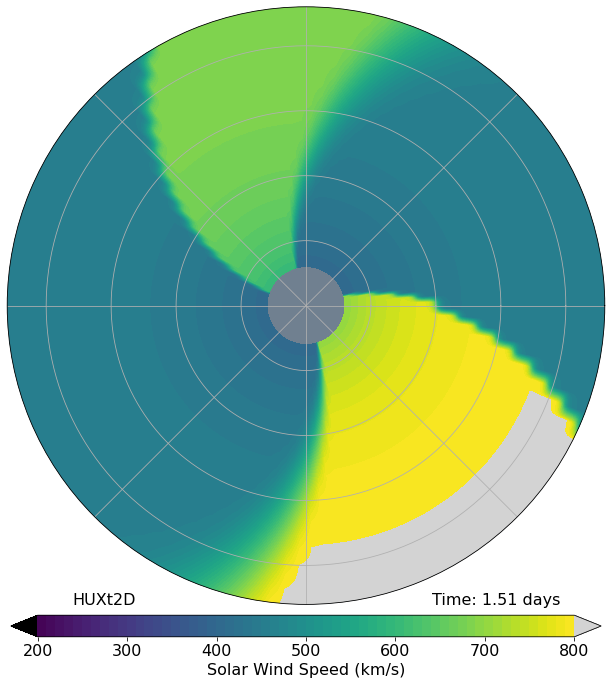

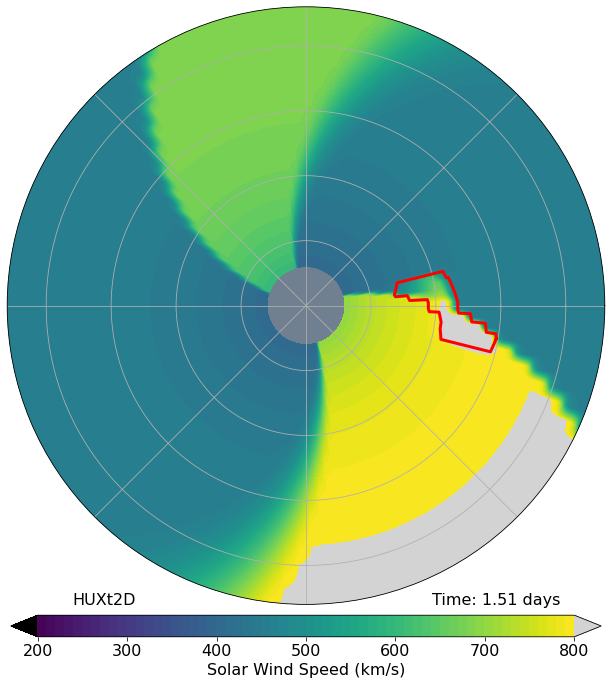

In [6]:
# Plot out the model at a specific time step for the ambient and ConeCME solutions.
t_interest = 1.5*u.day
model.plot(t_interest, 'ambient')
model.plot(t_interest, 'cme')

In [7]:
# Animate a MP4 of the CME solution. These are saved in HUXt>figures>HUXt2D
model.animate('cme', tag='cone_cme_test') # This takes about a minute too.

t:   0%|                                                                             | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_cone_cme_test_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_cone_cme_test_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_cone_cme_test_movie.mp4


In [8]:
# Model results can also be saved outside of the solve method.
out_path = model.save(tag='cone_cme_test')

# And loaded back in with
model2, cme_list2 = H.load_HUXt2D_run(out_path)

Text(0, 0.5, 'Y ($R_{sun}$)')

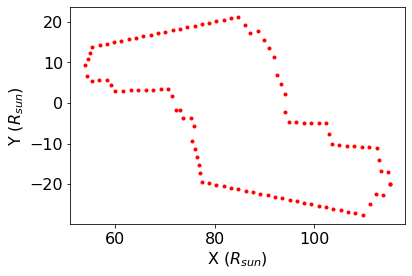

In [9]:
# If you want to get at the coordinates of the tracked CME boundary you can like.
cme = model2.cmes[0]
timestep = 50
rad = cme.coords[timestep]['r']
lon = cme.coords[timestep]['lon']
x = rad * np.cos(lon)
y = rad * np.sin(lon)

fig, ax = plt.subplots() # compare this with the boundary in the frame above.
ax.plot(x,y,'r.')
ax.set_xlabel('X ($R_{sun}$)')
ax.set_ylabel('Y ($R_{sun}$)')

In [10]:
#Both HUXt1D and HUXt2D can be run with multiple ConeCMEs.
# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt2D(cr_num=2100, simtime=5*u.day, dt_scale=4)

daysec = 86400
times = [0.5*daysec, 1.5*daysec, 3*daysec]
speeds = [850, 1000, 700]
lons = [0, 90, 300]
widths = [30, 40, 20]
thickness = [5, 4, 2]
cme_list = []
for t, l, w, v, thick in zip(times, lons, widths, speeds, thickness):
    cme = H.ConeCME(t_launch=t*u.s, longitude=l*u.deg, width=w*u.deg, v=v*model.kms, thickness=thick*u.solRad)
    cme_list.append(cme)

model.solve(cme_list, save=True, tag='multi_cones') # This takes a minute or so to run. 
model.animate('cme', tag='multi_cones')

t:   0%|                                                                             | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2100_multi_cones_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2100_multi_cones_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2100_multi_cones_movie.mp4


Help on Observer in module HUXt object:

class Observer(builtins.object)
 |  Observer(body, times)
 |  
 |  A class returning the HEEQ and Carrington coordinates of a specified Planet or spacecraft, for a given set of times.
 |  The positions are linearly interpolated from a 2-hour resolution ephemeris that spans 1974-01-01 until 2020-01-01.
 |  Allowed bodies are Earth, Venus, Mercury, STEREO-A and STEREO-B.
 |  
 |  Attributes:
 |      body: String name of the planet or spacecraft.
 |      lat: HEEQ latitude of body at all values of time.
 |      lat_c: Carrington latitude of body at all values of time.
 |      lon: HEEQ longitude of body at all values of time.
 |      lon_c: Carrington longitude of body at all values of time.
 |      r: HEEQ radius of body at all values of time.
 |      r_c: Carrington radius of body at all values of time.
 |      time: Array of Astropy Times
 |  
 |  Methods defined here:
 |  
 |  __init__(self, body, times)
 |      :param body: String indicating w

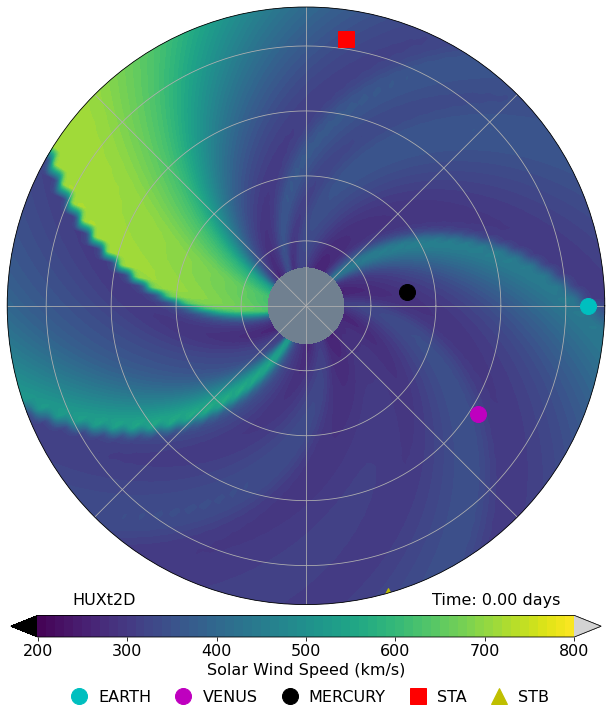

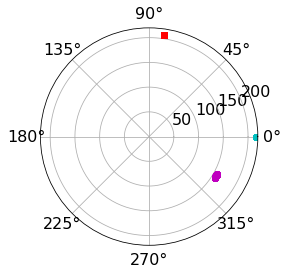

In [11]:
# There is also an ephemeris of the HEEQ and Carrington coordiates of Earth, Mercury, Venus, STEREO-A and STEREO-B
# These are automatically plotted on model solutions derived from a particular Carrington rotation.
model.plot(model.time_out[0])

# You can retrieve a bodies position at each model timestep like:
earth = model.get_observer('earth')
sta = model.get_observer('sta')
venus = model.get_observer('venus')

# The bodies HEEQ and Carrington coordinates are attributes.
help(earth)

# So to plot them:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(earth.lon, earth.r, 'co')
ax.plot(sta.lon, sta.r, 'rs')
ax.plot(venus.lon, venus.r, 'mo')

In [12]:
# Most of the model parameters are attributes of the HUXt1D(2D) classes, so can be accessed like:

# Model time step from the CFL condition:
print(model.dt)
# Output model time step
print(model.dt_out)

# A list of all attributes is in the documentation
help(model)

525.5287769784172 s
2102.115107913669 s
Help on HUXt2D in module HUXt object:

class HUXt2D(builtins.object)
 |  HUXt2D(v_boundary=<Quantity nan km / s>, cr_num=nan, lon_init=<Quantity 0. deg>, simtime=<Quantity 5. d>, dt_scale=1.0)
 |  
 |  A class containing the 2D HUXt model described in Owens et al. (2020, DOI: 10.1007/s11207-020-01605-3)
 |  
 |  Users must specify the solar wind speed boundary condition through either the v_boundary, or cr_num keyword
 |  arguments. Failure to do so defaults to a 400 km/s boundary. v_boundary takes precedence over cr_num, so specifying
 |  both results in only v_boundary being used.
 |  
 |  Model coordinate system is HEEQ radius and longitude.
 |  
 |  Attributes:
 |      cmes: A list of ConeCME instances used in the model solution.
 |      cr_num: If provided, this gives the Carrington rotation number of the selected period, else 9999.
 |      daysec: seconds in a day.
 |      dlon: Longitudinal grid spacing (in radians)
 |      dr: Radial grid